In [1]:
%%capture
## compile PyRoss for this notebook
import os
owd = os.getcwd()
os.chdir('../../')
%run setup.py install
os.chdir(owd)

In [2]:
%matplotlib inline
import numpy as np
import pyross
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
#from matplotlib import rc; rc('text', usetex=True)

## 1) Generate a trajectory
We generate a test trajectory of the SIR class on a population with two ages groups.

In [3]:
M = 2                # the population has two age groups
N = 5e4              # and this is the total population

# set the age structure
fi = np.array([0.25, 0.75])  # fraction of population in age age group
Ni = N*fi

# set the contact structure
C = np.array([[18., 9.], [3., 12.]])


def contactMatrix(t):   
    return C

# duration of simulation and data file
Tf = 100;  
Nf=Tf+1; 

# set up initial condition
Ia0 = np.array([10, 10])  # each age group has asymptomatic infectives
Is0 = np.array([10, 10])  # and also symptomatic infectives
R0  = np.array([0, 0])    # there are no recovered individuals initially
S0  = Ni - (Ia0 + Is0 + R0)

x0 = np.concatenate((S0, Ia0, Is0))

beta = 0.02
alpha = 0.2
gIa = 1/7 
gIs = 1/7 
fsa = 1

def contactMatrix(t):
    return C

parameters = {'alpha':alpha, 'beta':beta, 'gIa':gIa, 'gIs':gIs,'fsa':fsa}
true_parameters = {'alpha':alpha, 'beta':beta, 'gIa':gIa, 'gIs':gIs,'fsa':fsa}

# use pyross stochastic to generate traj and save 
sto_model = pyross.stochastic.SIR(parameters, M, Ni)
data = sto_model.simulate(S0, Ia0, Is0, contactMatrix, Tf, Nf)
data_array = data['X']

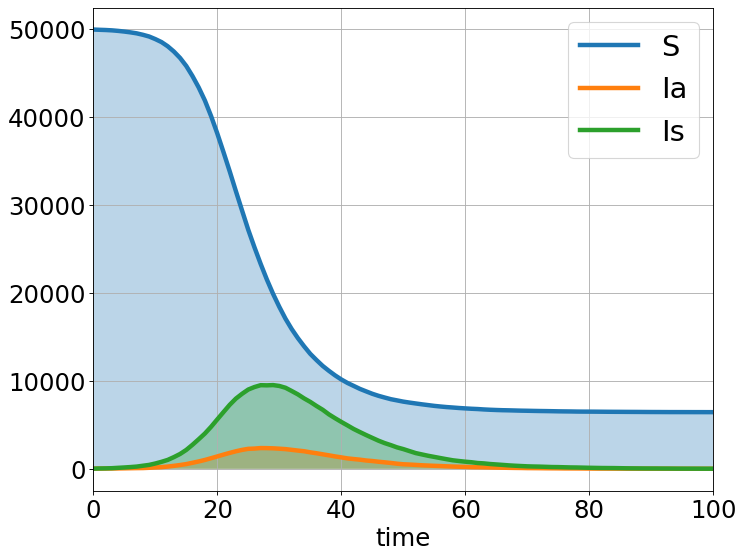

In [4]:
fig = plt.figure(num=None, figsize=(10, 8), dpi=80, facecolor='w', edgecolor='k')
plt.rcParams.update({'font.size': 22})
t = data['t']

plt.fill_between(t, 0, np.sum(data_array[:, :M], axis=1),  alpha=0.3)
plt.plot(t, np.sum(data_array[:, :M], axis=1), '-', label='S', lw=4)

plt.fill_between(t, 0, np.sum(data_array[:, M:2*M], axis=1), alpha=0.3)
plt.plot(t, np.sum(data_array[:, M:2*M], axis=1), '-', label='Ia', lw=4)

plt.fill_between(t, 0, np.sum(data_array[:, 2*M:3*M], axis=1), alpha=0.3)
plt.plot(t, np.sum(data_array[:, 2*M:3*M], axis=1), '-', label='Is', lw=4)

plt.legend(fontsize=26)
plt.grid() 
plt.xlabel(r'time') 
plt.autoscale(enable=True, axis='x', tight=True)

In [5]:
# load the data and rescale to intensive variables 
Tf_inference = 20 # truncate to only getting the first few datapoints 
Nf_inference = Tf_inference+1

x = (data_array[:Nf_inference]).astype('float')

### 2) Make the Spp class using model_spec

In [6]:
inference_parameters = {
    'alpha' : alpha, 
    'beta' : beta, 
    'gIa' : gIa, 
    'gIs' : gIs
}

def parameter_mapping(input_parameters):
    output_parameters = {
        'betaIa' : input_parameters['beta'] * input_parameters['alpha'],
        'betaIs' : input_parameters['beta'] * (1 - input_parameters['alpha']),
        'gIa' : input_parameters['gIa'],
        'gIs' : input_parameters['gIs'] 
    }
    return output_parameters


model_spec = {
    "classes" : ["S", "Ia", "Is"],

    "S" : {
        "linear"    : [],
        "infection" : [ ["Ia", "-betaIa"], ["Is", "-betaIa"], ["Ia", "-betaIs"], ["Is", "-betaIs"]]
    },
    "Ia" : {
        "linear"    : [ ["Ia", "-gIa"] ],
        "infection" : [ ["Ia", "betaIa"], ["Is", "betaIa"] ]
    }, 
    "Is" :{
        "linear"    : [ ["Is", "-gIs"] ],
        "infection" : [ ["Is", "betaIs"], ["Ia", "betaIs"]]
    }
}

# initialise the estimator 
estimator = pyross.inference.Spp(model_spec, inference_parameters, M, Ni, parameter_mapping=parameter_mapping)

# check integrate 
logp = estimator.obtain_minus_log_p(inference_parameters, x, Tf_inference, contactMatrix)
print(logp)

408.0801221554519


In [7]:
# Define the prior (Gamma prior around guess of parameter with defined std. deviation)
alpha_g = 0.1
alpha_std = 0.1 

beta_g = 0.01
beta_std = 0.01

gIa_g = 0.1
gIa_std = 0.1

gIs_g = 0.1
gIs_std = 0.1

# compute -log_p for the initial guess 
guessed_parameters = {
    'alpha' : alpha_g, 
    'beta' : beta_g, 
    'gIa' : gIa_g, 
    'gIs' : gIs_g
}

logp = estimator.obtain_minus_log_p(guessed_parameters, x, Tf_inference, contactMatrix)
print(logp) 

4689.289148190864


In [8]:
## inference 
ftol = 1e-6  # Stopping criterion for minimisation (relative change in function value)
eps = 1e-4 
param_priors = {
    'alpha':{
        'mean': alpha_g, 
        'std': alpha_std, 
        'bounds': [eps, 0.5]
    }, 
    'beta':{
        'mean': beta_g, 
        'std': beta_std, 
        'bounds': [eps, 0.5]
    }, 
    'gIa':{
        'mean': gIa_g, 
        'std': gIa_std, 
        'bounds': [eps, 0.6]
    }, 
    'gIs':{
        'mean': gIs_g, 
        'std': gIs_std, 
        'bounds': [eps, 0.6]
    }
}

estimator.set_lyapunov_method('euler')
res = estimator.infer_parameters(x, Tf_inference, contactMatrix, param_priors, 
                                    tangent=False, 
                                    global_max_iter=20, local_max_iter=200, 
                                    global_atol=1, ftol=ftol, verbose=True)

Starting global minimisation...
(8_w,16)-aCMA-ES (mu_w=4.8,w_1=32%) in dimension 4 (seed=3012433914, Tue Jul 14 16:35:11 2020)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     16 1.247031474154817e+03 1.0e+00 1.13e+00  1e-02  1e-01 0:00.1
    2     32 1.369794264683052e+03 1.4e+00 1.26e+00  1e-02  1e-01 0:00.3
    3     48 4.758773611876206e+02 1.6e+00 1.30e+00  1e-02  1e-01 0:00.4
Global optimisation: Maximum number of iterations reached.
Optimal value (global minimisation):  401.7026623454159
Starting local minimisation...
Optimal value (local minimisation):  400.87688026250817


In [9]:
print("True parameters:")
print(inference_parameters)

print("\nInferred parameters:")
best_estimates = res['map_dict']
print(best_estimates)

True parameters:
{'alpha': 0.2, 'beta': 0.02, 'gIa': 0.14285714285714285, 'gIs': 0.14285714285714285}

Inferred parameters:
{'alpha': 0.16058884299112558, 'beta': 0.020225006876648747, 'gIa': 0.07392817120129946, 'gIs': 0.16054687720395755}


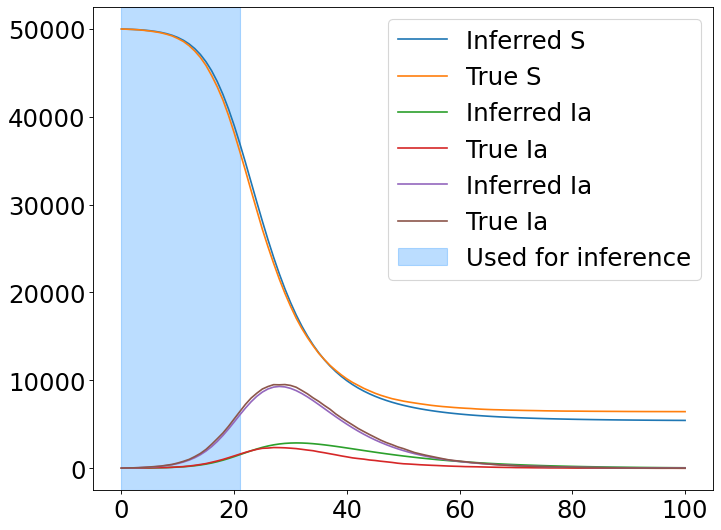

In [10]:
Nf = 101
Tf = Nf-1

estimator.set_det_model(best_estimates)
x_det = estimator.integrate(x[0], 0, Tf, Nf)
x = data['X']
fig = plt.figure(num=None, figsize=(10, 8), dpi=80, facecolor='w', edgecolor='k')
plt.rcParams.update({'font.size': 22})
plt.plot(np.sum(x_det[:, :M], axis=1), label='Inferred S')
plt.plot(np.sum(x[:, :M], axis=1), label='True S')
plt.plot(np.sum(x_det[:, M:2*M], axis=1), label='Inferred Ia')
plt.plot(np.sum(x[:, M:2*M], axis=1), label='True Ia')
plt.plot(np.sum(x_det[:, 2*M:3*M], axis=1), label='Inferred Ia')
plt.plot(np.sum(x[:, 2*M:3*M], axis=1), label='True Ia')
plt.axvspan(0, Nf_inference, 
           label='Used for inference',
           alpha=0.3, color='dodgerblue')
plt.legend()
plt.show() 